In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import time
import deepdish as dd
from sequence_annotation.genome_handler.seq_container import AnnSeqContainer
from sequence_annotation.data_handler.fasta import read_fasta
h5=dd.io.load('../io/Arabidopsis_thaliana/data/2019_02_20/result/result_dist_to_five_1000_dist_to_three_1000_merged.h5')
fasta = read_fasta('../io/Arabidopsis_thaliana/data/2019_02_20/result/result_dist_to_five_1000_dist_to_three_1000_merged.fasta')
ann_seqs = AnnSeqContainer().from_dict(h5)

Using TensorFlow backend.


In [14]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
space={
    'cnn_kernel_size':64,
    'cnn_num':8,
    'rnn_num':2,
    'cnn_output':32,
    'rnn_output':2,
    'PWM':False#hp.choice('PWM',[True,False])
}

In [3]:
from sequence_annotation.genome_handler.utils import loader
from sequence_annotation.pytorch.space_finder import ASModelSpaceFinder

In [4]:
len(ann_seqs)

2865

In [5]:
simplify_map={'exon':['exon'],'intron':['intron','mix'],'other':['other']}
selected_fasta,selected_seqs,o_f,o_s = loader(fasta,ann_seqs,simplify_map=simplify_map,ratio=1,
                                          min_len=4000,max_len=6000,num_max=int(len(ann_seqs)/10))

/home/sequence_annotation/sequence_annotation/genome_handler/ann_seq_processor.py:218: RuntimeWarning: invalid value encountered in true_divide
  vecs.append(np.nan_to_num(temp/temp))


(array([6., 3., 2., 3., 3., 2., 3., 3., 1., 2.]),
 array([4091. , 4262.5, 4434. , 4605.5, 4777. , 4948.5, 5120. , 5291.5,
        5463. , 5634.5, 5806. ]),
 <a list of 10 Patch objects>)

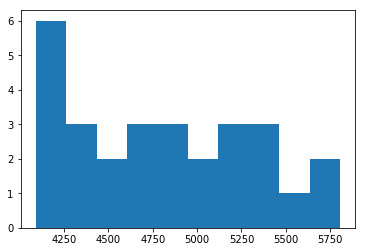

In [6]:
seqs_len = [len(seq) for seq in selected_seqs]
from matplotlib import pyplot
pyplot.hist(seqs_len)

In [7]:
len(selected_fasta)

28

In [ ]:
trials = Trials()
trainer = ASModelSpaceFinder(selected_fasta,selected_seqs,'../io/record/arabidopsis_2019_03_13',
                             outlier_fasta=o_f,outlier_seq=o_s,
                             batch_size=32,lr=1e-3)
best = fmin(trainer.objective, space, algo=tpe.suggest, max_evals=32,trials=trials)

20 {'other': 41713.0, 'exon': 42469.0, 'intron': 13147.0}
6 {'other': 12000.0, 'exon': 10436.0, 'intron': 6334.0}
2 {'other': 4000.0, 'exon': 4305.0, 'intron': 99.0}
1 {'rnn_num': 2, 'cnn_output': 32, 'PWM': False, 'rnn_output': 2, 'cnn_num': 8, 'cnn_kernel_size': 64}
Processing data...
Processing model..
Compiling model...
Processing worker...
Executing...
Start working(2019-03-14 10:02:26)
CNN time 0
RNN time 15
CRF decode time 8
CRF forward time 5.1128504276275635
CNN time 0
RNN time 2
CRF decode time 4
CRF forward time 4.342848062515259
Shuffle data
Shuffle data
CNN time 0
RNN time 4
CRF decode time 6
[[ 0.001 -0.001 -0.001]
 [-0.001 -0.001 -0.001]
 [-0.001 -0.001  0.001]]
1 240.73061299324036 {'val_F1_intron': 0.0, 'val_F1_other': 0.31031559728742825, 'val_loss': 22950.890625, 'loss': 8582.3271484375, 'F1_exon': 0.4578988934538969, 'F1_other': 0.030744688565006163, 'val_macro_F1': 0.17003725771179035, 'val_F1_exon': 0.18605614834766393, 'macro_F1': 0.4260735937631557, 'val_accurac

In [ ]:
import deepdish as dd
dd.io.save(trainer.root+'/records.h5',trainer.records)
dd.io.save(trainer.root+'/space_result.h5',trainer.space_result)

In [ ]:
import torch
torch.cuda.current_device()

In [ ]:
torch.Tensor().to([0,1,2])